# Processamento Regional
Prof. Dr. Gustavo Resque  
MSc. Tiago Araújo

In [1]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import widgets
from IPython.display import display
from ipywidgets import *
import cv2

In [2]:
def noisy(noise_typ,image):
    if noise_typ == "gauss":
        row,col,ch= image.shape
        mean = 0
        var = 0.1
        sigma = var**0.5
        gauss = np.random.normal(mean,sigma,(row,col,ch))
        gauss = gauss.reshape(row,col,ch)
        noisy = image + gauss
        return noisy
    elif noise_typ == "s&p":
        row,col,ch = image.shape
        s_vs_p = 0.8
        amount = 0.2
        out = np.copy(image)
        # Salt mode
        num_salt = np.ceil(amount * image.size * s_vs_p)
        coords = [np.random.randint(0, i - 1, int(num_salt))
              for i in image.shape]
        out[coords] = 255

        # Pepper mode
        num_pepper = np.ceil(amount* image.size * (1. - s_vs_p))
        coords = [np.random.randint(0, i - 1, int(num_pepper))
            for i in image.shape]
        out[coords] = 0
        return out
    elif noise_typ == "poisson":
        vals = len(np.unique(image))
        vals = 2 ** np.ceil(np.log2(vals))
        noisy = np.random.poisson(image * vals) / float(vals)
        return noisy
    elif noise_typ =="speckle":
        row,col,ch = image.shape
        gauss = np.random.randn(row,col,ch)
        gauss = gauss.reshape(row,col,ch)        
        noisy = image + image * gauss
        return noisy

In [3]:
#img = cv2.imread("dataset/cameraman.tif", 1)
#n = noisy("s&p",img)
#cv2.imwrite('dataset/noisy.tif',cv2.cvtColor(n,cv2.COLOR_BGR2GRAY))

# Operação Regional

* Uma operação realizada em uma amostra que representa uma região e produz um único resultado
* Podem ser descritas na forma de função

\begin{equation*}
    s = T(I[i:n,j:m]) \\
    s\,=\,valor\,de\,saída \\
    T\,=\,operação\,aplicada \\
    I\,=\,Imagem\,de\,entrada \\
    i,n,j,m\,=\,Índices\,da\,subregião\,da\,imagemm
\end{equation*}

# Convolução

* Uma operação linear que emprega uma grade de coeficientes, conhecida como **_kernel_**
* O kernel determina a vizinhança de determinado pixel e define como essa vizinhança afeta o resultado

In [25]:
def get_ax(rows=1, cols=1):
    fig, axes = plt.subplots(figsize=(4,4), dpi = 100, nrows=rows, ncols=cols)
    if rows == 1 and cols == 1:
        axes.clear()
        axes.get_xaxis().set_visible(False)
        axes.get_yaxis().set_visible(False)
    else:
        for ax in axes:
            ax.clear()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
    return axes
     
def desenha_matriz(textarr, colors):
    txarr = textarr
    clrs = colors
    size = 100
    linewidth = size//100 if size//100 > 0 else 1

    im = np.zeros((txarr.shape[0]*size, txarr.shape[0]*size, 3), dtype=np.uint8)
    im[:,:] = (255,255,255)
    for i in range(txarr.shape[0]):
        for j in range(txarr.shape[1]):
            limx_start, limx_end = i*size, (i+1)*size
            limy_start, limy_end = j*size, (j+1)*size
            im[limx_start:limx_end, limy_start:limy_end] = clrs[i,j]
            
            cortext = 255 - clrs[i,j]
            cortext = cortext.astype(np.uint8)
            
            if len(txarr.shape) >= 3:
                cortext = (int(cortext[0]), int(cortext[1]), int(cortext[2]))
            else:
                cortext = (int(cortext), int(cortext), int(cortext))
            
            text = str(textarr[i,j])
            padding = 0 if len(text) == 1 else 2*len(text)
            
            cv2.putText(im, text, (limy_start + size//(3 + padding), (limx_start + size//2) + size//8),
                        cv2.FONT_HERSHEY_PLAIN, size//(30+padding), cortext, int(linewidth*2.5) , cv2.LINE_AA)

    for i in range(txarr.shape[0]):
        im[(i+1)*size-linewidth:linewidth+(i+1)*size,:,:] = 255 - im[(i+1)*size-linewidth:linewidth+(i+1)*size,:,:]
    for i in range(txarr.shape[1]):
        im[:,(i+1)*size-linewidth:linewidth+(i+1)*size,:] = 255 - im[:,(i+1)*size-linewidth:linewidth+(i+1)*size,:]
            
    return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

In [26]:
texto1 = np.array([
[-1,0,1],
[-1,0,1],
[-1,0,1]
], dtype=np.int)

texto2 = np.array([
[30,50,2,44,40],
[40,60,1,20,20],
[70,90,120,120,120],
[100,80,61,50,50],
[90,200,61,60,60]
], dtype=np.int)

cores2 = np.array([
[200,200,200,200,200],
[200,255,255,255,200],
[200,255,0,255,200],
[200,255,255,255,200],
[200,200,200,200,200]
], dtype=np.int)

cores1 = np.array([
[255,255,255],
[255, 0 ,255],
[255,255,255]
], dtype=np.uint8)

texto_media = np.array([
[1,1,1],
[1,1,1],
[1,1,1]
], dtype=np.int)


<IPython.core.display.Javascript object>


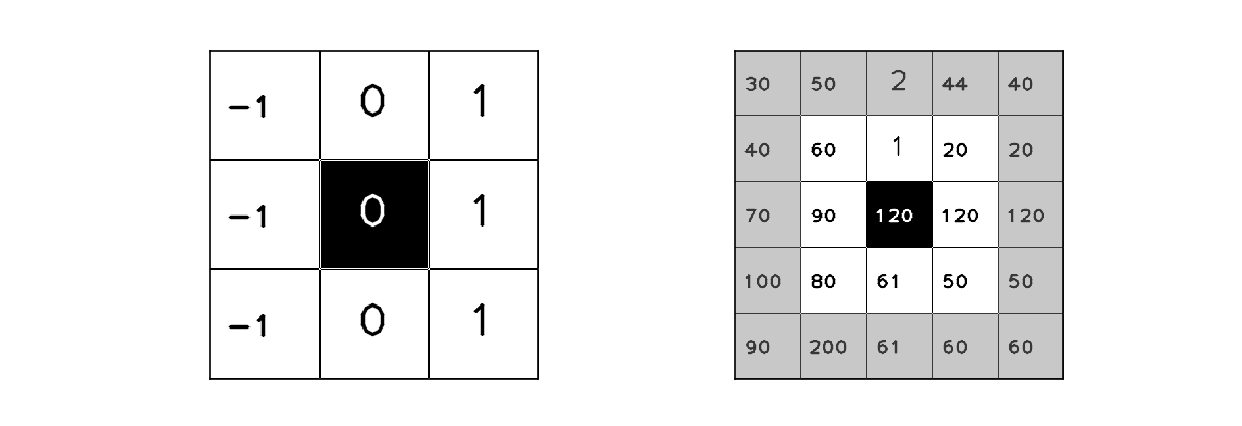

In [27]:
im = desenha_matriz(texto1, cores1)
im2 = desenha_matriz(texto2, cores2)
axes = get_ax(1,2)
axes[0].imshow(im)
axes[1].imshow(im2)

# Suavização

* Diminui o ruído de uma imagem
* Causa um borramento

In [29]:
def suavizacao(caminhos):
    
    fig, axes = plt.subplots(figsize=(8,3), dpi = 100, nrows=1, ncols=4)
    plt.tight_layout()

    start = caminhos[2]

    radio = widgets.RadioButtons(
        options=caminhos,
        value=start,
        description='Imagem: ',
        disabled=False
    )
    slider = IntSlider(min=3,max=17,step=2,value=7,description='Kernel')
    slider_std = IntSlider(min=0,max=10,step=1,value=0,description='DvPd')

    def update(args):
        path = args['new']
        img = cv2.cvtColor(cv2.imread(path,1),cv2.COLOR_BGR2RGB)
        media = cv2.blur(img,(slider.value,slider.value))
        mediana = cv2.medianBlur(img,slider.value)
        gaussiana = cv2.GaussianBlur(img,(slider.value,slider.value),slider_std.value)
        
        for ax in axes:
            ax.clear()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
        axes[0].imshow(img, cmap='gray')
        axes[0].set_title('Original')
        axes[1].imshow(media, cmap='gray')
        axes[1].set_title('Media')
        axes[2].imshow(mediana, cmap='gray')
        axes[2].set_title('Mediana')
        axes[3].imshow(gaussiana, cmap='gray')
        axes[3].set_title('Gaussiana')
    
    def updateKernel(args):
        update({'new':radio.value})
            
    radio.observe(update, names='value');
    slider.observe(updateKernel, names='value')
    slider_std.observe(updateKernel, names='value')

    update({'new':start})
    display(radio);
    display(slider);
    display(slider_std);

### Kernel da média:

<IPython.core.display.Javascript object>


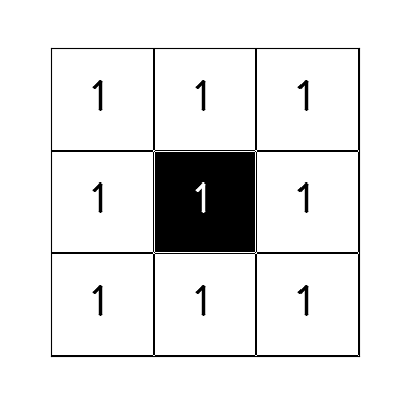

In [30]:
get_ax().imshow(desenha_matriz(texto_media, cores1))

<IPython.core.display.Javascript object>


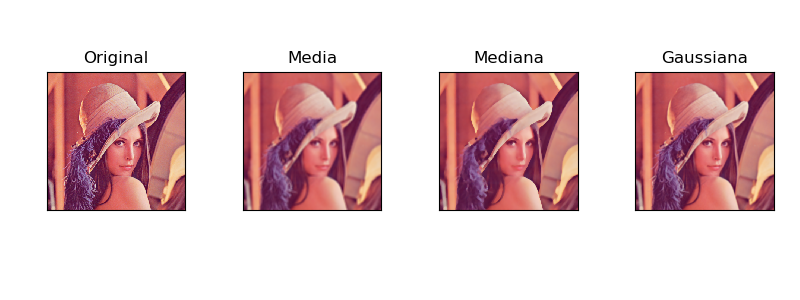

RadioButtons(description='Imagem: ', index=2, options=('dataset/cameraman.tif', 'dataset/lenna.png', 'dataset/…

IntSlider(value=7, description='Kernel', max=17, min=3, step=2)

IntSlider(value=0, description='DvPd', max=10)

In [31]:
suavizacao(['dataset/cameraman.tif','dataset/lenna.png','dataset/people_street.jpg','dataset/noisy.tif'])

# Sharpening

* Inverso da suavização
* Destaca as bordas da imagem
* Aumenta o contraste

In [16]:
def sharpening(caminhos):
    fig, axes = plt.subplots(figsize=(10,3), dpi = 100, nrows=1, ncols=3)
    for ax in axes:
        ax.clear()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    start = caminhos[2]
    plt.tight_layout()

    radio = widgets.RadioButtons(
        options=caminhos,
        value=start,
        description='Imagem: ',
        disabled=False
    )
    slider = IntSlider(min=3,max=17,step=2,value=7,description='Kernel')
    
    def update(args):
        path = args['new']
        img = cv2.cvtColor(cv2.imread(path,1),cv2.COLOR_BGR2GRAY)
        
        media = cv2.blur(img,(slider.value,slider.value))
        residual = img - media.astype(np.int16)
        sharpen = img + residual
        
        sharpen = cv2.convertScaleAbs(sharpen)
        
        axes[0].imshow(img, cmap='gray')        
        axes[0].set_title('Original')
        axes[1].imshow(residual, cmap='gray')
        axes[1].set_title('Residual')
        axes[2].imshow(sharpen, cmap='gray')
        axes[2].set_title('Sharpen')

    def updateKernel(args):
        update({'new':radio.value})
        
    radio.observe(update, names='value');
    slider.observe(updateKernel, names='value')

    update({'new':start})
    display(radio);
    display(slider);

<IPython.core.display.Javascript object>


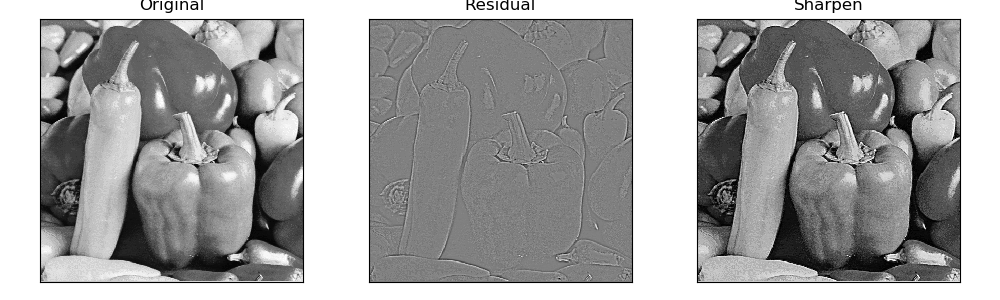

RadioButtons(description='Imagem: ', index=2, options=('dataset/noisy.tif', 'dataset/lenna.png', 'dataset/igre…

IntSlider(value=7, description='Kernel', max=17, min=3, step=2)

In [35]:
sharpening(['dataset/noisy.tif','dataset/lenna.png','dataset/igrejase.jpg','dataset/peppers.tif', 'dataset/veropeso.jpg'])